<a href="https://colab.research.google.com/github/chinmayeeadiga/emotion-detection/blob/main/Emotion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**EMOTION DETECTION BY TEXT**

Number of emotion classes : 6

Types of emotion classes :
*   Sadness
*   Joy
*   Love
*   Anger
*   Fear
*   Surprise

Dataset Used : Emotion Dataset by dair-ai

Models Used : Convolutional Neural Network (CNN)

In [1]:
#importing dependencies
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
#loading the dataset
splits = {'train': 'split/train-00000-of-00001.parquet', 'validation': 'split/validation-00000-of-00001.parquet', 'test': 'split/test-00000-of-00001.parquet'}
X_train = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["train"])
X_val = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["validation"])
X_test = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["test"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
# cleaning the data
!pip install wordcloud emoji
import re
import emoji
import string
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|@\w+", '', text)
    text = emoji.demojize(text, delimiters=(" ", " "))
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens
              if word not in stop_words and word.isalpha()]
    return " ".join(tokens)

X_train['clean_text'] = X_train['text'].apply(preprocess)
X_test['clean_text'] = X_test['text'].apply(preprocess)
X_val['clean_text'] = X_val['text'].apply(preprocess)

In [4]:
# getting the data ready
y_train = X_train['label']
y_test = X_test['label']
y_val = X_val['label']

X_train = X_train[['clean_text']]
X_train.columns = ['clean_text']
X_test = X_test[['clean_text']]
X_test.columns = ['clean_text']
X_val = X_val[['clean_text']]
X_val.columns = ['clean_text']

**VISUALIZATION**

/tmp/ipython-input-5-658360236.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette='Set2')


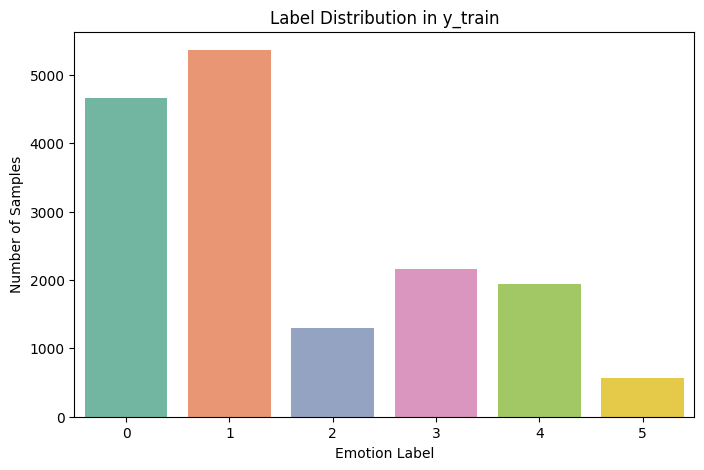

In [5]:
#bar plots
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(x=y_train, palette='Set2')
plt.title("Label Distribution in y_train")
plt.xlabel("Emotion Label")
plt.ylabel("Number of Samples")
plt.show()

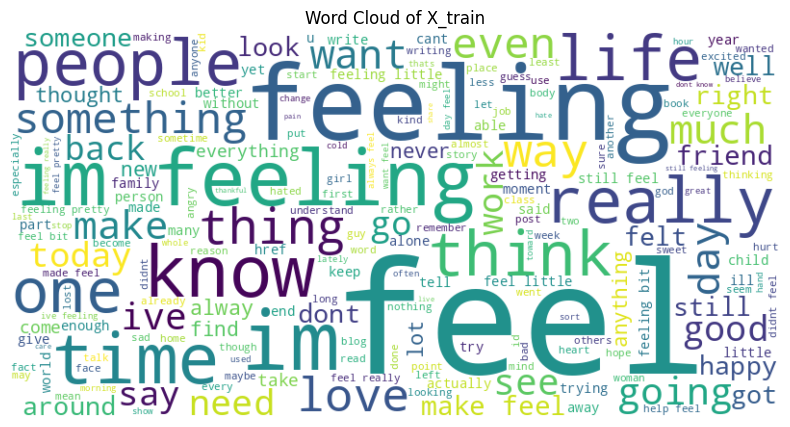

In [6]:
#word clouds
from wordcloud import WordCloud

text = " ".join(X_train['clean_text'].tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of X_train")
plt.show()

**WORD EMBEDDINGS**

In [7]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-07-15 09:39:33--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-07-15 09:39:33--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-07-15 09:39:34--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.6’

gl

In [8]:
embeddings_index = {}
with open("glove.6B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [9]:
#Tokenization
tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train['clean_text'])

X_train_seq = tokenizer.texts_to_sequences(X_train['clean_text'])
X_val_seq = tokenizer.texts_to_sequences(X_val['clean_text'])
X_test_seq = tokenizer.texts_to_sequences(X_test['clean_text'])

In [10]:
#Padding
max_len = max(len(seq) for seq in X_train_seq)
X_train = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val = pad_sequences(X_val_seq, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

In [11]:
#Load GloVe Embeddings
embedding_index = {}
with open('/content/glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

In [12]:
#Create Embedding Matrix
embedding_dim = 100
word_index = tokenizer.word_index
num_words = min(20000, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

**CNN MODELS**

In [13]:
#Prepare labels (convert to categorical)
num_classes = y_train.nunique()
y_train_new = to_categorical(y_train, num_classes=num_classes)
y_val_new = to_categorical(y_val, num_classes=num_classes)
y_test_new = to_categorical(y_test, num_classes=num_classes)

In [14]:
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Concatenate
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

input_layer = Input(shape=(max_len,))

embedding_layer = Embedding(input_dim=num_words,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=True)(input_layer)

conv_3 = Conv1D(128, kernel_size=3, activation='relu')(embedding_layer)
conv_3 = BatchNormalization()(conv_3)
pool_3 = GlobalMaxPooling1D()(conv_3)

conv_4 = Conv1D(128, kernel_size=4, activation='relu')(embedding_layer)
conv_4 = BatchNormalization()(conv_4)
pool_4 = GlobalMaxPooling1D()(conv_4)

conv_5 = Conv1D(128, kernel_size=5, activation='relu')(embedding_layer)
conv_5 = BatchNormalization()(conv_5)
pool_5 = GlobalMaxPooling1D()(conv_5)

merged = Concatenate()([pool_3, pool_4, pool_5])

dropout = Dropout(0.5)(merged)
dense = Dense(128, activation='relu')(dropout)
output = Dense(num_classes, activation='softmax')(dense)

model = Model(inputs=input_layer, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 35, 100)   │  1,348,200 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 33, 128)   │     38,528 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 32, 128)   │     51,328 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 31, 128)   │     64,128 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 33, 128)   │        512 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 128)   │        512 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 128)   │        512 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 384)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     49,280 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 6)         │        774 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,553,774 (5.93 MB)

 Trainable params: 1,553,006 (5.92 MB)

 Non-trainable params: 768 (3.00 KB)

In [15]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_cnn_model.h5', save_best_only=True, monitor='val_loss')

history = model.fit(X_train, y_train_new,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_val, y_val_new),
                    callbacks=[early_stop, checkpoint])


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.4353 - loss: 2.0263

500/500 ━━━━━━━━━━━━━━━━━━━━ 36s 63ms/step - accuracy: 0.4355 - loss: 2.0249 - val_accuracy: 0.7910 - val_loss: 0.5938
Epoch 2/20
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8158 - loss: 0.5105

500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.8159 - loss: 0.5102 - val_accuracy: 0.9045 - val_loss: 0.2627
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9197 - loss: 0.2242

500/500 ━━━━━━━━━━━━━━━━━━━━ 39s 58ms/step - accuracy: 0.9197 - loss: 0.2242 - val_accuracy: 0.9150 - val_loss: 0.2263
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9508 - loss: 0.1370

500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 61ms/step - accuracy: 0.9508 - loss: 0.1370 - val_accuracy: 0.9150 - val_loss: 0.2224
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.9635 - loss: 0.0973 - val_accuracy: 0.9180 - val_loss: 0.2553
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step - accuracy: 0.9688 - loss: 0.0869 - val_accuracy: 0.9210 - val_loss: 0.2402
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 61ms/step - accuracy: 0.9759 - loss: 0.0670 - val_accuracy: 0.9185 - val_loss: 0.2275
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 46s 72ms/step - accuracy: 0.9804 - loss: 0.0545 - val_accuracy: 0.9170 - val_loss: 0.2754
Epoch 9/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 36s 62ms/step - accuracy: 0.9790 - loss: 0.0569 - val_accuracy: 0.9250 - val_loss: 0.2826


In [16]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_new, axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [17]:
# evaluating the model
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
accuracy = accuracy_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

Accuracy: 0.9225
Precision: 0.8844
Recall:    0.8837
F1 Score:  0.8814

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       581
           1       0.96      0.93      0.94       695
           2       0.75      0.92      0.83       159
           3       0.92      0.92      0.92       275
           4       0.90      0.89      0.90       224
           5       0.82      0.68      0.74        66

    accuracy                           0.92      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.93      0.92      0.92      2000



**USING THE MODEL**

In [18]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
max_len = 35

def preprocess_text(text):
    text = text.lower()
    text = emoji.demojize(text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

import gradio as gr
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_train)

def predict_emotion(text):
    cleaned = preprocess_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=max_len, padding="post")
    pred = model.predict(padded)[0]
    threshold = 0.3

    top_indices = np.where(pred > threshold)[0]
    if len(top_indices) == 0:
        return "Neutral"

    emotions = [str(e) for e in label_encoder.classes_[top_indices]]
    return ", ".join(emotions)


In [19]:
import ipywidgets as widgets
from IPython.display import display

input_box = widgets.Textarea(placeholder='Enter text here', layout=widgets.Layout(width='100%', height='100px'))
output_box = widgets.Output()
button = widgets.Button(description='Detect Emotion')

def on_click(b):
    output_box.clear_output()
    text = input_box.value
    with output_box:
        print(predict_emotion(text))

button.on_click(on_click)

display(input_box, button, output_box)


Textarea(value='', layout=Layout(height='100px', width='100%'), placeholder='Enter text here')

Button(description='Detect Emotion', style=ButtonStyle())

Output()

In [20]:
import pickle
from google.colab import files

files.download("best_cnn_model.h5")

with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
files.download("tokenizer.pkl")

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)
files.download("label_encoder.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>